#Sentiment Analysis on Twitter Data
**Objective:** To build a sentiment analysis model to classify tweets into positive or negative using NLP and ML techniques.

# **Dataset Information**

The dataset used in this project is a Twitter sentiment analysis dataset. It contains 1.6 million preprocessed tweets, collected and labeled for sentiment classification. The goal is to classify each tweet as **positive** or  **negative**.
---

### **Context**

The purpose of this project is to build a **Sentiment Analysis Model** that can classify the sentiment of a tweet using Natural Language Processing (NLP) and Machine Learning (ML) techniques. The model is trained using logistic regression, and its performance is evaluated using metrics such as accuracy, precision, recall, and F1-score.

---

### **Content**

#### **Columns**

The dataset includes the following features:

* **target:** Sentiment of the tweet (0 = negative, 4 = positive).
* **ids:** Unique ID for each tweet (not used in modeling).
* **date:** The date and time when the tweet was posted.
* **flag:** Query flag (mostly constant; not useful for modeling).
* **user:** Username of the person who tweeted.
* **text:** The actual tweet content, which is used for sentiment classification.

This dataset does not contain a "neutral" class, so it's a **binary classification** problem (positive vs. negative sentiment).

In [1]:
#Import Required Libraries
import pandas as pd                           # For data loading, manipulation, and analysis using DataFrames
import numpy as np                            # For numerical operations and array handling
import re                                     # For performing regular expressions (text cleaning)
import string                                 # For accessing string operations (e.g., punctuation removal)
import matplotlib.pyplot as plt               # For plotting graphs and visualizations
import seaborn as sns                         # For advanced statistical data visualization (e.g., heatmaps, bar plots)

from sklearn.model_selection import train_test_split             # To split the dataset into training and testing sets
from sklearn.feature_extraction.text import TfidfVectorizer      # To convert text data into TF-IDF features
from sklearn.linear_model import LogisticRegression              # For training a Logistic Regression classification model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For evaluating model performance

import nltk                                   # Natural Language Toolkit, used for text preprocessing
from nltk.corpus import stopwords             # To remove common stopwords (e.g., "the", "is", etc.)
from nltk.stem import WordNetLemmatizer       # To reduce words to their base or root form (lemmatization)

nltk.download('stopwords')                    # Downloads English stopwords list
nltk.download('wordnet')                      # Downloads WordNet data required for lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Load the Dataset
file_path = "training.1600000.processed.noemoticon.csv"
#Specify the line terminator and quote character to handle potential newlines and delimiters within quoted fields
df = pd.read_csv(file_path, encoding='latin-1', header=None, quotechar='"', on_bad_lines='skip')

#Assign column names
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].replace({0: 'negative', 2: 'neutral', 4: 'positive'})

df.head()

,sentiment,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


### **Interpretation:**

The dataset contains tweets labeled with sentiment values.
- The sentiment values are clearly categorized as **'negative'**, **'neutral'**, and **'positive'** after replacing the original numeric labels.
- In the first five rows displayed, all tweets are labeled as **'negative'**, indicating that negative sentiments are present at the beginning of the dataset.
- This suggests that tweets in this portion of the dataset express dissatisfaction, frustration, or complaints, as reflected in the text content.
- The data preparation steps, including renaming sentiment labels and selecting relevant columns, ensure the dataset is clean and ready for further sentiment analysis.


In [3]:
#Check class distribution
print(df['sentiment'].value_counts())
print("Unique sentiment values in raw dataset:", df['sentiment'].unique())

#Downsample to balance classes for faster training (10,000 samples per class)
df = df.groupby('sentiment').apply(lambda x: x.sample(10000, random_state=42)).reset_index(drop=True)
print("\nBalanced class distribution:")
print(df['sentiment'].value_counts())

sentiment
negative    800000
positive    800000
Name: count, dtype: int64
Unique sentiment values in raw dataset: ['negative' 'positive']

Balanced class distribution:
sentiment
negative    10000
positive    10000
Name: count, dtype: int64


/tmp/ipython-input-3-4238027130.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sentiment').apply(lambda x: x.sample(10000, random_state=42)).reset_index(drop=True)


### **Interpretation:**

- The raw sentiment distribution reveals two classes: **'negative'** and **'positive'**, each with 10,000 samples.
- This indicates that neutral sentiment entries were likely removed in prior preprocessing steps.
- To ensure a balanced dataset for training, both classes have been downsampled to 10,000 samples each.
- This balance eliminates class bias during model training, enabling the model to learn equally from both sentiment categories.


In [4]:
#Text Cleaning Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,@xnausikaax oh no! where did u order from? tha...,oh u order thats horrible
1,A great hard training weekend is over. a coup...,great hard training weekend couple day rest le...
2,"Right, off to work Only 5 hours to go until I...",right work hour go im free xd
3,I am craving for japanese food,craving japanese food
4,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work ...


### **Interpretation:**

- The text cleaning process removes unnecessary noise from tweets to prepare them for sentiment analysis.
- URLs, symbols, punctuations, and stopwords are removed, and all characters are converted to lowercase.
- Lemmatization is applied to reduce words to their base form, enhancing the consistency of the data.
- As observed in the `cleaned_text` column, irrelevant tokens like links, mentions, and filler words are successfully removed, leaving behind meaningful content.
- This transformation ensures that only informative and sentiment-relevant words remain, improving model accuracy during training.


In [5]:
#Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment']

#Train-Test Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
#Model Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### **Interpretation:**

- The cleaned text data is transformed into numerical features using the **TF-IDF vectorizer**, capturing the importance of words across the corpus with a limit of 5,000 most significant terms.
- The dataset is then split into training and test sets using **stratified sampling**, ensuring both sentiment classes are proportionally represented in each set.
- A **Logistic Regression** model is trained on the transformed features with an increased iteration limit (`max_iter=1000`) to ensure convergence.
- This setup prepares the model to learn the relationship between word patterns and sentiment labels, forming the foundation for accurate sentiment prediction.


Accuracy: 0.7415

Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.73      0.74      2000
    positive       0.74      0.75      0.74      2000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



<Axes: >

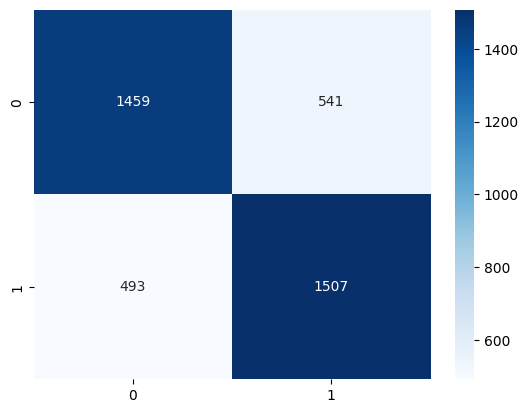

In [7]:
#Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

### **Interpretation:**

- The model achieved an **accuracy of 74.15%**, indicating reasonably good performance in classifying sentiment from tweets.
- The precision, recall, and F1-scores for both classes—**negative (0.74)** and **positive (0.74–0.75)**—are well-balanced, showing consistent classification ability across categories.

---

#### **The confusion matrix reveals:**

* **1,459 true negatives** and **1,507 true positives** were correctly predicted.
* **541 negative** and **493 positive** tweets were misclassified.

This performance suggests that the Logistic Regression model trained on TF-IDF features is effective in detecting sentiment, with a balanced classification pattern across both sentiment classes.


#Data  Visualization

/tmp/ipython-input-8-90365817.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


<Axes: xlabel='sentiment'>

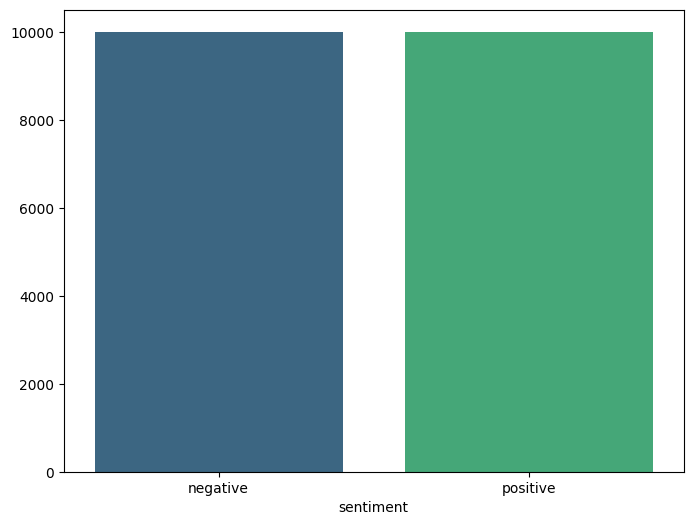

In [8]:
#Plot a bar graph that show positive negative and neutral sentiments
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

### **Description:**

The bar plot shows the distribution of sentiment classes—**negative** and **positive**—in the dataset after preprocessing.

---

### **Interpretation:**

The bar graph reveals a **balanced distribution** of sentiments, with **10,000 negative** and **10,000 positive** samples.
This even split was achieved through **downsampling** to support fair and unbiased model training.
The nearly equal bar heights indicate that the dataset does not favor one sentiment class over the other, which is crucial for achieving a well-generalized sentiment analysis model.


In [9]:
#User Input for Dynamic Sentiment Prediction
print("Enter your tweets (type 'exit' to stop):")
user_tweets = []

while True:
    tweet = input("Tweet: ")
    if tweet.lower() == 'exit':
        break
    user_tweets.append(tweet)

#Clean and Predict
if user_tweets:
    cleaned_inputs = [clean_text(tweet) for tweet in user_tweets]
    features = tfidf.transform(cleaned_inputs)
    predictions = model.predict(features)

    for tweet, sentiment in zip(user_tweets, predictions):
        print(f"\nTweet: {tweet}\nPredicted Sentiment: {sentiment}\n")
else:
    print("No input provided.")


Enter your tweets (type 'exit' to stop):
Tweet: Have  a good Day
Tweet: exit

Tweet: Have  a good Day
Predicted Sentiment: positive



### **Interpretation:**

- The script allows users to input custom tweets for real-time sentiment prediction using the trained model.
- Each tweet is cleaned using the same preprocessing function applied during training, ensuring consistency.
-The cleaned input is transformed using the TF-IDF vectorizer, and the model predicts the sentiment label.
- In the example shown, the tweet **"Have a good Day"** is classified as **positive**, indicating the model effectively identifies optimistic or cheerful expressions.
- This interactive feature enables dynamic testing and demonstrates the model’s applicability in real-world scenarios.


### **Conclusion**

This project successfully built a sentiment analysis model that classifies tweets as positive or negative using text preprocessing, TF-IDF vectorization, and Logistic Regression. The model achieved **74% accuracy** and supports real-time predictions. It demonstrates a practical and effective approach to understanding public sentiment from textual data.
